In [2]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X,y=make_blobs(random_state=0)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
lr=LogisticRegression()
lr.fit(X_train,y_train)
print("test score:{:.3f}".format(lr.score(X_test,y_test)))

test score:0.880


# 1 交叉验证

## 1.1 sklearn中的交叉验证

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

iris=load_iris()
logreg=LogisticRegression()
scores=cross_val_score(logreg,iris.data,iris.target)
print("Cross-validation scores\n{}".format(scores))

Cross-validation scores
[0.96078431 0.92156863 0.95833333]


In [4]:
scores=cross_val_score(logreg,iris.data,iris.target,cv=5)
print("Cross-validation scores\n{}".format(scores))

Cross-validation scores
[1.         0.96666667 0.93333333 0.9        1.        ]


In [5]:
print("Average Cross-validation scores:{:.3f}".format(scores.mean()))

Average Cross-validation scores:0.960


## 1.2 交叉验证 优缺点

#优点
1、充分利用数据，避免仅利用了部分
2、可以显示模型对训练集数据的敏感性
#缺点
1、速度慢k倍

## 1.3 交叉验证策略

In [6]:
import matplotlib.pyplot as plt
import mglearn

mglearn.plots.plot_cross_validation()

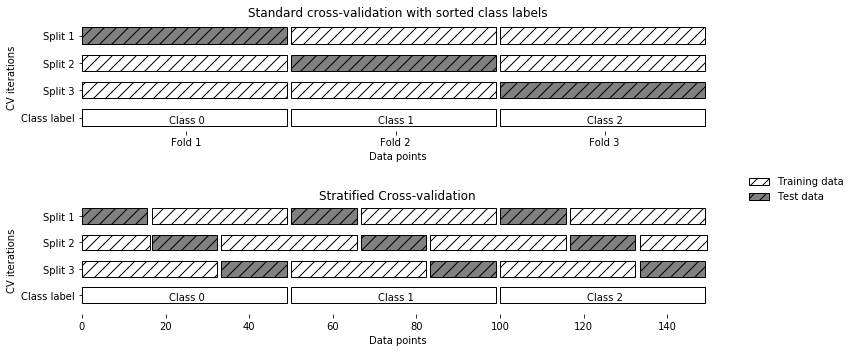

In [7]:
#分层k折交叉验证
mglearn.plots.plot_stratified_cross_validation()

### 1）交叉验证分离器

In [8]:
# 比如：重现打乱数据
from sklearn.model_selection import KFold

kfold=KFold(n_splits=3,shuffle=True,random_state=0)
print("Cross-validation score:\n{}".format(cross_val_score(logreg,iris.data,iris.target,cv=kfold)))

Cross-validation score:
[0.9  0.96 0.96]


### 2）留一法交叉验证

In [9]:
#每折包含一个样本点
from sklearn.model_selection import LeaveOneOut

loo=LeaveOneOut()
scores=cross_val_score(logreg,iris.data,iris.target,cv=loo)
print("Number of iterations:{}".format(len(scores)))
print("Mean accuracies:{:.3f}".format(scores.mean()))

Number of iterations:150
Mean accuracies:0.953


### 3）打乱划分交叉验证

In [10]:
#控制每次使用比例，迭代次数
from sklearn.model_selection import ShuffleSplit

shuffle_split=ShuffleSplit(test_size=.5,train_size=.5,n_splits=10)
scores=cross_val_score(logreg,iris.data,iris.target,cv=shuffle_split)
print("Cross-validation score:\n{}".format(scores))

Cross-validation score:
[0.90666667 0.90666667 0.92       0.96       0.93333333 0.92
 0.98666667 0.97333333 0.97333333 0.92      ]


### 4）分组交叉验证

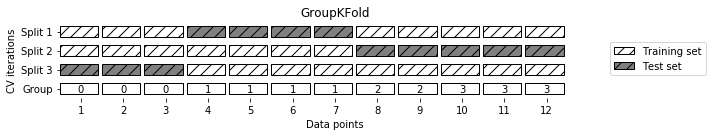

In [11]:
mglearn.plots.plot_group_kfold()

In [12]:
from sklearn.model_selection import GroupKFold

X,y=make_blobs(n_samples=12,random_state=0)
group=[0,0,0,1,1,1,1,2,2,3,3,3]
scores=cross_val_score(logreg,X,y,group,cv=GroupKFold(n_splits=3))
print("Cross-validation score:\n{}".format(scores))

Cross-validation score:
[0.75       0.8        0.66666667]


# 2网格搜索

## 2.1简单网格搜索

In [13]:
from sklearn.svm import SVC

X_train,X_test,y_train,y_test=train_test_split(iris.data,iris.target,random_state=0)
print("Size of training set:{} size of test set:{}".format(X_train.shape[0],X_test.shape[0]))

best_score=0
best_parameters={}

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        #对每一种参数组合都训练一个SVC
        svm=SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        #测试集上评估
        score=svm.score(X_test,y_test)
        #如果得到了更高的分数，则保存该分数和对应的参数
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}
print("best score:{:.3f}".format(best_score))
print("best parameters:{}".format(best_parameters))

Size of training set:112 size of test set:38
best score:0.974
best parameters:{'C': 100, 'gamma': 0.001}


## 2.2参数过拟合的风险和验证集

In [14]:
#训练集：构建模型  验证集（开发集）：选择模型参数  测试集：评估所选参数性能

from sklearn.svm import SVC

X_trainval,X_test,y_trainval,y_test=train_test_split(iris.data,iris.target,random_state=0)
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval,random_state=1)
print("Size of training set:{} size of val set:{}".format(X_train.shape[0],X_val.shape[0]))

best_score=0
best_parameters={}

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        #对每一种参数组合都训练一个SVC
        svm=SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        #测试集上评估
        score=svm.score(X_val,y_val)
        #如果得到了更高的分数，则保存该分数和对应的参数
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}
            
svm=SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score=svm.score(X_test,y_test)

print("best score:{:.3f}".format(best_score))
print("best parameters:{}".format(best_parameters))
print("test score with best parameters:{:.3f}".format(test_score))

Size of training set:84 size of val set:28
best score:0.964
best parameters:{'C': 10, 'gamma': 0.001}
test score with best parameters:0.921


## 2.3带交叉验证的网格搜索

In [15]:
#交叉验证：消除在分训练集与验证集时数据敏感性

import numpy as np

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        svm=SVC(gamma=gamma,C=C)
        scores=cross_val_score(svm,X_trainval,y_trainval,cv=5)
        score=np.mean(scores)
        if score>best_score:
            best_score=score
            best_parameters={'gamma':gamma,'C':C}
svm=SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score=svm.score(X_test,y_test)

print("best score:{:.3f}".format(best_score))
print("best parameters:{}".format(best_parameters))
print("test score with best parameters:{:.3f}".format(test_score))

best score:0.973
best parameters:{'gamma': 0.01, 'C': 100}
test score with best parameters:0.974


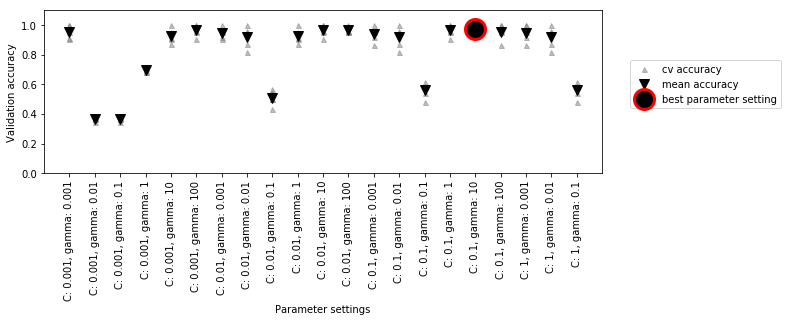

In [16]:
mglearn.plots.plot_cross_val_selection()

### sklearn网格搜索模块

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid={'C':[0.001,0.01,0.1,1,10,100],
           'gamma':[0.001,0.01,0.1,1,10,100]}

grid_search=GridSearchCV(SVC(),param_grid,cv=5,return_train_score=True)
X_train,X_test,y_train,y_test=train_test_split(iris.data,iris.target,random_state=0)
grid_search.fit(X_train,y_train)
test_score=grid_search.score(X_test,y_test)

print("test score is:{:.3f}".format(test_score))

test score is:0.974


### 1)分析交叉验证结果

In [18]:
import pandas as pd
results=pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000886,0.000513,0.000230,0.000022,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000839,0.000131,0.000330,0.000074,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000628,0.000042,0.000232,0.000027,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.000616,0.000027,0.000222,0.000010,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.000625,0.000050,0.000233,0.000038,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


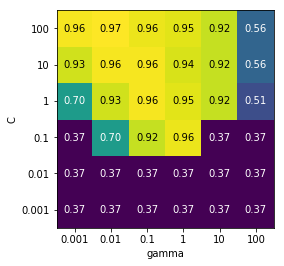

In [19]:
scores=np.array(results.mean_test_score).reshape(6,6)

mglearn.tools.heatmap(scores,xlabel='gamma',xticklabels=param_grid['gamma'],
                     ylabel='C',yticklabels=param_grid['C'],cmap='viridis')

### 2)在非网格空间搜索

In [20]:
param_grid=[{'kernel':['rbf'],
            'C':[0.001,0.01,0.1,1,10,100],
           'gamma':[0.001,0.01,0.1,1,10,100]},
           {'kernel':['linear'],
           'C':[0.001,0.01,0.1,1,10,100]}]

grid_search=GridSearchCV(SVC(),param_grid,cv=5)
grid_search.fit(X_train,y_train)
print("best scores:{:.3f}".format(grid_search.best_score_))
print("best parameters:{}".format(grid_search.best_params_))

best scores:0.973
best parameters:{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


### 3)使用不同的交叉验证策略进行网格搜索

#### 嵌套交叉验证

In [21]:
#表示网格找到的额最佳参数下模型的泛化性能好坏

scores=cross_val_score(GridSearchCV(SVC(),param_grid,cv=5),
                      iris.data,iris.target,cv=5)
print("Cross-validation score: ",scores)
print("mean cross-validation score:{:.3f}".format(scores.mean()))

Cross-validation score:  [0.96666667 1.         0.9        0.96666667 1.        ]
mean cross-validation score:0.967


#### 交叉验证与网格搜索并行化

# 3评估指标与评分

## 3.1二分类指标

### 1）错误类型： 假正例（第一类错误）、假反例（第二类错误）

### 2）不平衡数据集

In [24]:
from sklearn.datasets import load_digits

digits=load_digits()
y=digits.target==9

X_train,X_test,y_train,y_test=train_test_split(digits.data,y,random_state=0)

from sklearn.dummy import DummyClassifier
dummy_majority=DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
pred_most_frequent=dummy_majority.predict(X_test)

print("Unique predicted labels:{}".format(np.unique(pred_most_frequent)))
print("Test score:{:.2f}".format(dummy_majority.score(X_test,y_test)))

Unique predicted labels:[False]
Test score:0.90


In [27]:
from sklearn.tree import DecisionTreeClassifier

tree=DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)
pred_tree=tree.predict(X_test)

print("Unique predicted labels:{}".format(np.unique(pred_tree)))
print("Test score:{:.2f}".format(tree.score(X_test,y_test)))

Unique predicted labels:[False  True]
Test score:0.92


In [30]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression().fit(X_train,y_train)
pred_lr=lr.predict(X_test)

print("Unique predicted labels:{}".format(np.unique(pred_lr)))
print("Test score:{:.2f}".format(lr.score(X_test,y_test)))

Unique predicted labels:[False  True]
Test score:0.98


### 3）混淆矩阵

In [31]:
from sklearn.metrics import confusion_matrix

confusion=confusion_matrix(y_test,pred_lr)
print("confusion matrix:\n{}".format(confusion))

confusion matrix:
[[399   4]
 [  7  40]]


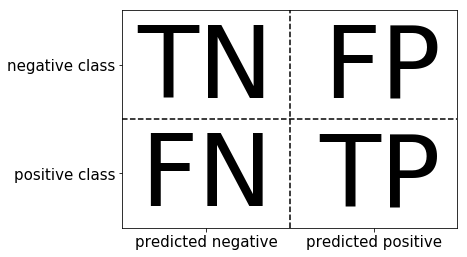

In [32]:
mglearn.plots.plot_binary_confusion_matrix()

In [33]:
print("Most frequet:\n{}".format(confusion_matrix(y_test,pred_most_frequent)))
print("DecisionTree:\n{}".format(confusion_matrix(y_test,pred_tree)))
print("LogisticRegression:\n{}".format(confusion_matrix(y_test,pred_lr)))

Most frequet:
[[403   0]
 [ 47   0]]
DecisionTree:
[[390  13]
 [ 24  23]]
LogisticRegression:
[[399   4]
 [  7  40]]


### 准确率、召回率、f-score

准确率(precision)：真正例（TP）/(真正例（TP）+假正例（FP））  应用场景：限制假正例的数量  比如：新药研制

召回率(recall)： 真正例（TP）/（真正例（TP）+假反例（FN））  应用场景：限制假反例   比如：癌症预测

f-socre：2*precision*ecall)/(precision+recall)

In [35]:
from sklearn.metrics import f1_score

print("most frequent:{:.2f}".format(f1_score(y_test,pred_most_frequent)))
print("decision tree:{:.2f}".format(f1_score(y_test,pred_tree)))
print("logistic regression:{:.2f}".format(f1_score(y_test,pred_lr)))

most frequent:0.00
decision tree:0.55
logistic regression:0.88


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test,pred_most_frequent,target_names=["not nine","nine"]))

             precision    recall  f1-score   support

   not nine       0.90      1.00      0.94       403
       nine       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
print(classification_report(y_test,pred_tree,target_names=["not nine","nine"]))

             precision    recall  f1-score   support

   not nine       0.94      0.97      0.95       403
       nine       0.64      0.49      0.55        47

avg / total       0.91      0.92      0.91       450



In [40]:
print(classification_report(y_test,pred_lr,target_names=["not nine","nine"]))

             precision    recall  f1-score   support

   not nine       0.98      0.99      0.99       403
       nine       0.91      0.85      0.88        47

avg / total       0.98      0.98      0.98       450



### 4）考虑不确定性

In [69]:
#from sklearn.datasets import make_blobs
from mglearn.datasets import make_blobs

X,y=make_blobs(n_samples=(400,50),centers=2,cluster_std=[7.0,2],random_state=22)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
svc=SVC(gamma=.05).fit(X_train,y_train)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


In [70]:
print(classification_report(y_test,svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



In [71]:
y_pred_lower_threshold=svc.decision_function(X_test)>-.8
print(classification_report(y_test,y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



### 5）准确率-召回率曲线

/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)


Text(0,0.5,'Recall')

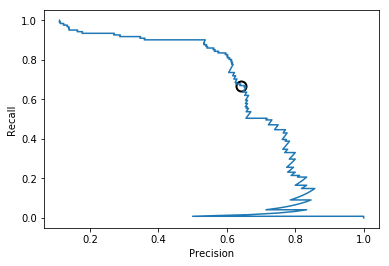

In [74]:
from sklearn.metrics import precision_recall_curve

X,y=make_blobs(n_samples=(4000,500),centers=2,cluster_std=[7.0,2],random_state=22)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

svc=SVC(gamma=.05).fit(X_train,y_train)
precision,recall,thresholds=precision_recall_curve(y_test,svc.decision_function(X_test))

close_zero=np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label="threshold zero",
        fillstyle="none",c='k',mew=2)
plt.plot(precision,recall,label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

In [76]:
from sklearn.metrics import average_precision_score

ap_svc=average_precision_score(y_test,svc.decision_function(X_test))
print("ap svc:{:.3f}".format(ap_svc))

ap svc:0.666


### 6）受试者工作特征（ROC）与AUC

真正例率： 召回率

假正例率：假正例（FP）/（假正例（FP）+真反例（TN））

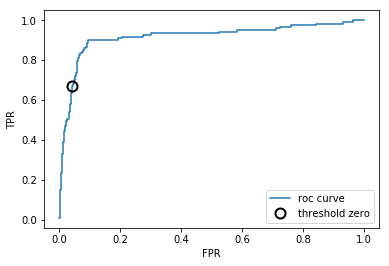

In [80]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_test,svc.decision_function(X_test))
plt.plot(fpr,tpr,label="roc curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
close_zero=np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero],tpr[close_zero],'o',markersize=10,label="threshold zero",
        fillstyle="none",c='k',mew=2)
plt.legend(loc=4)

In [83]:
from sklearn.metrics import roc_auc_score

svc_auc=roc_auc_score(y_test,svc.decision_function(X_test))
print("svc auc :{:.3f}".format(svc_auc))

svc auc :0.916


## 3.2多分类指标

In [84]:
from sklearn.metrics import accuracy_score

X_train,X_test,y_train,y_test=train_test_split(digits.data,digits.target,random_state=0)
lr=LogisticRegression().fit(X_train,y_train)
pred=lr.predict(X_test)
print("Accuracy:{:.3f}".format(accuracy_score(y_test,pred)))
print("confusion matrix:\n{}".format(confusion_matrix(y_test,pred)))

Accuracy:0.953
confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


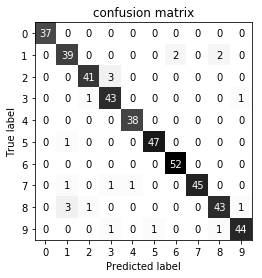

In [85]:
scores_image=mglearn.tools.heatmap(confusion_matrix(y_test,pred),xlabel="Predicted label",
                                  ylabel="True label",xticklabels=digits.target_names,
                                  yticklabels=digits.target_names,cmap=plt.cm.gray_r,fmt="%d")
plt.title("confusion matrix")
plt.gca().invert_yaxis()

In [87]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.89      0.91      0.90        43
          2       0.95      0.93      0.94        44
          3       0.90      0.96      0.92        45
          4       0.97      1.00      0.99        38
          5       0.98      0.98      0.98        48
          6       0.96      1.00      0.98        52
          7       1.00      0.94      0.97        48
          8       0.93      0.90      0.91        48
          9       0.96      0.94      0.95        47

avg / total       0.95      0.95      0.95       450



In [88]:
print("Micro avg score:{:.3f}".format(f1_score(y_test,pred,average="micro")))
print("Macro avg score:{:.3f}".format(f1_score(y_test,pred,average="macro")))

Micro avg score:0.953
Macro avg score:0.954


## 3.4回归指标 R2

## 3.5模型中使用评估指标

In [91]:
print("Default scoring:{}".format(cross_val_score(SVC(),digits.data,digits.target==9)))
print("Accuracy scoring:{}".format(cross_val_score(SVC(),digits.data,digits.target==9,scoring="accuracy")))
print("AUC scoring:{}".format(cross_val_score(SVC(),digits.data,digits.target==9,scoring="roc_auc")))

Default scoring:[0.89983306 0.89983306 0.89983306]
Accuracy scoring:[0.89983306 0.89983306 0.89983306]
AUC scoring:[0.99372294 0.98957947 0.99594929]
